# MESQUAL 304: Folium KPI Visualization System

This notebook demonstrates how to visualize KPI data using MESQUAL's folium system. We'll explore how computed metrics and indicators can be mapped to interactive geographic visualizations with automatic coloring, legends, and multi-scenario analysis.

## Introduction

Building on the model data visualization from mesqual_401, this notebook focuses on visualizing computed KPIs (Key Performance Indicators). We'll cover:

1. **KPI Data Items**: How KPIs integrate with the folium visualization system
2. **KPI Collection Visualization**: Automatic mapping of KPI collections to maps
3. **Dynamic Coloring**: Using PropertyMapper.from_kpi_value() for data-driven styling
4. **Multi-Scenario KPI Maps**: Comparing KPIs across different scenarios
5. **KPI Filtering and Grouping**: Selective visualization of KPI subsets
6. **Interactive Features**: Tooltips, popups, and layer controls for KPI exploration

This approach enables sophisticated analysis of energy system performance metrics with geographic context.

## Setup

First, we need to set up the environment. If you are on Colab, the first cell will clone and install all dependencies. You will have to restart the session afterwards and continue with cell 2. If you are in a local environment, make sure that you have followed the Getting started steps in the README, so that mesqual and all requirements are installed.

In [1]:
import os

if "COLAB_RELEASE_TAG" in os.environ:
    import importlib.util

    def is_module_available(module_name):
        return importlib.util.find_spec(module_name) is not None

    if os.path.exists("mesqual-vanilla-studies") and is_module_available("mesqual"):
        print("✅ Environment already set up. Skipping installation.")
    else:
        print("🔧 Setting up Colab environment...")
        !git clone --recursive https://github.com/helgeesch/mesqual-vanilla-studies.git
        %cd mesqual-vanilla-studies/

        !pip install git+https://github.com/helgeesch/mesqual -U
        !pip install git+https://github.com/helgeesch/mesqual-pypsa -U
        !pip install -r requirements.txt

        print('✅ Setup complete. 🔁 Restart the session, then skip this cell and continue with the next one.')
else:
    print("🖥️ Running locally. No setup needed.")

🖥️ Running locally. No setup needed.


In [2]:
import os

if "COLAB_RELEASE_TAG" in os.environ:
    import sys
    sys.path.append('/content/mesqual-vanilla-studies')
    os.chdir('/content/mesqual-vanilla-studies')
else:
    def setup_notebook_env():
        """Set working directory to repo root and ensure it's in sys.path."""
        import os
        import sys
        from pathlib import Path

        def find_repo_root(start_path: Path) -> Path:
            current = start_path.resolve()
            while current != current.parent:
                if (current / 'vanilla').exists():
                    return current
                current = current.parent
            raise FileNotFoundError(f"Repository root not found from: {start_path}")

        repo_root = find_repo_root(Path.cwd())
        os.chdir(repo_root)
        if str(repo_root) not in sys.path:
            sys.path.insert(0, str(repo_root))

    setup_notebook_env()

try:
    from mesqual import StudyManager
except ImportError:
    raise ImportError("❌ 'mesqual' not found. If you're running locally, make sure you've installed all dependencies as described in the README.")

if not os.path.isdir("studies"):
    raise RuntimeError(f"❌ 'studies' folder not found. Make sure your working directory is set to the mesqual-vanilla-studies root. Current working directory: {os.getcwd()}")

print("✅ Environment ready. Let's go!")

✅ Environment ready. Let's go!


In [3]:
import folium

from mesqual.kpis import FlagAggKPIBuilder, ComparisonKPIBuilder, Aggregations, ValueComparisons
import mesqual.visualizations.folium_viz_system as fiz
import mesqual.visualizations.value_mapping_system as vap
from mesqual.visualizations.folium_viz_system.legends import ContinuousColorscaleLegend  # TODO: move to fiz.legend.
from mesqual.utils.folium_utils.background_color import set_background_color_of_map
from mesqual.utils.plotly_utils.plotly_theme import colors
from vanilla.notebook_config import configure_clean_output_for_jupyter_notebook
from vanilla.conditional_renderer import ConditionalRenderer

configure_clean_output_for_jupyter_notebook()
renderer = ConditionalRenderer()

## Load Study Data and Setup KPIs

Let's load our study data and define comprehensive KPIs for visualization:

In [4]:
# Load the StudyManager with PyPSA Scigrid-DE network data
from studies.study_01_intro_to_mesqual.scripts.setup_study_manager import get_scigrid_de_study_manager
study = get_scigrid_de_study_manager()

print("Study scenarios:")
for dataset in study.scen.datasets:
    print(f"  📊 {dataset.name}")
    
print("\nComparisons:")
for dataset in study.comp.datasets:
    print(f"  🔄 {dataset.name}")

Study scenarios:
  📊 base
  📊 solar_150
  📊 solar_200
  📊 wind_150
  📊 wind_200

Comparisons:
  🔄 solar_150 vs base
  🔄 solar_200 vs base
  🔄 wind_150 vs base
  🔄 wind_200 vs base


In [5]:
# Clear any existing KPIs
study.scen.clear_kpi_collection_for_all_child_datasets()
study.comp.clear_kpi_collection_for_all_child_datasets()

# Get base dataset to access control areas
ds_base = study.scen.get_dataset('base')
generators = ds_base.fetch('generators').query("carrier.isin(['Gas', 'Hard Coal', 'Brown Coal'])").index.to_list()

# Define scenario KPIs using KPI system

market_price_definitions = (
    FlagAggKPIBuilder()
    .for_flag('control_areas_t.vol_weighted_marginal_price')
    .with_aggregation(Aggregations.Mean)
    .build()
)

# Generation capacity utilization KPIs
generation_definitions = (
    FlagAggKPIBuilder()
    .for_flag('generators_t.p')
    .with_aggregation(Aggregations.Mean)
    .build()  # .for_all_objects() is default
)
kpi_defs = market_price_definitions + generation_definitions
study.scen.add_kpis_from_definitions_to_all_child_datasets(kpi_defs)
print(f"Added KPIs to scenario datasets.")

# Define comparison KPIs (calculate changes between scenarios)
print("\nGenerating comparison KPIs...")
comparison_defs = (
    ComparisonKPIBuilder(kpi_defs)
    .with_comparisons([
        ValueComparisons.Increase,  # Absolute change
        ValueComparisons.Delta      # Also Delta for compatibility
    ])
    .build()
)
study.comp.add_kpis_from_definitions_to_all_child_datasets(comparison_defs)
print(f"Added comparison KPIs to comparison datasets")

# Get merged collections
scenario_kpi_collection = study.scen.get_merged_kpi_collection()
comparison_kpi_collection = study.comp.get_merged_kpi_collection()

print(f"\nTotal scenario KPIs: {scenario_kpi_collection.size}")
print(f"Total comparison KPIs: {comparison_kpi_collection.size}")

print("\n✅ All KPIs generated successfully!")

Added KPIs to scenario datasets.

Generating comparison KPIs...
Added comparison KPIs to comparison datasets

Total scenario KPIs: 7135
Total comparison KPIs: 22832

✅ All KPIs generated successfully!


## Part 1: Basic KPI Visualization

Let's start with a simple visualization of market prices across control areas for all scenarios:

Found 20 price KPIs


KPICollectionMapVisualizer:  80%|████████  | 16/20 [00:00<00:00, 499.33it/s]


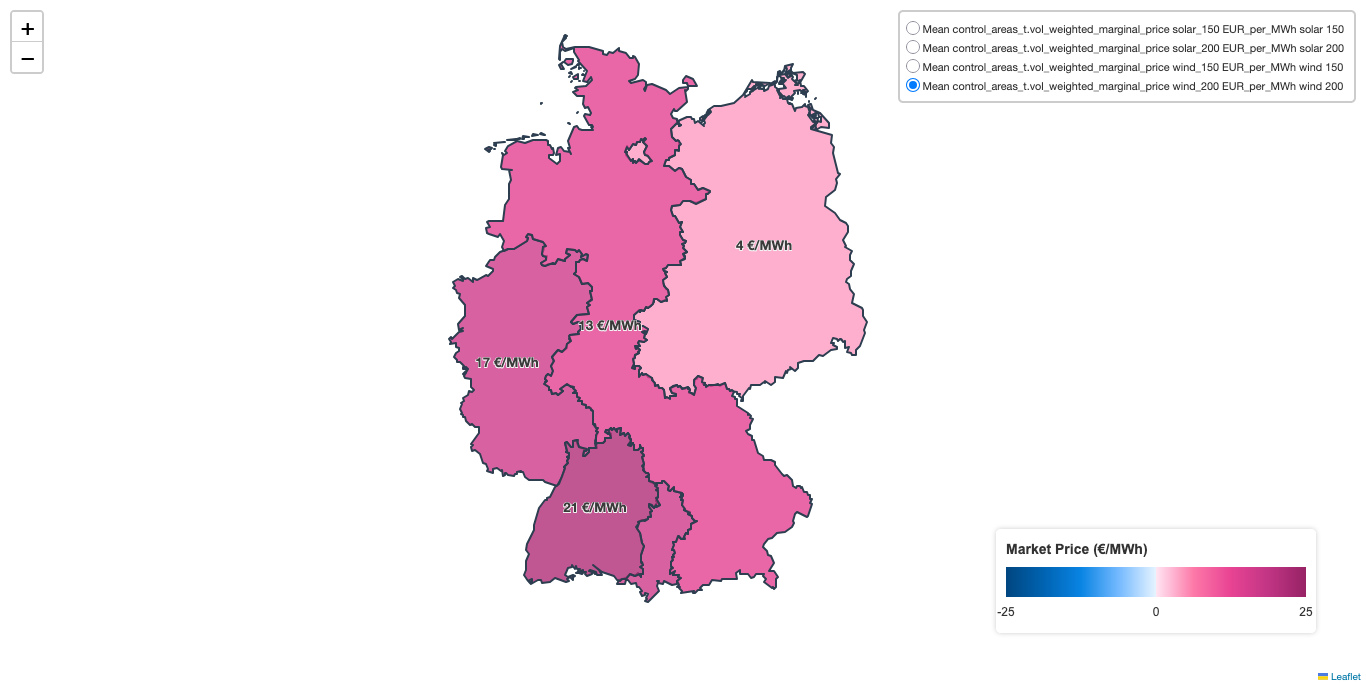

In [6]:
# Create colorscale for market prices
price_colorscale = vap.SegmentedContinuousColorscale(
    segments={
        (-25, 0): colors.sequential.shades_of_blue[::-1],
        (0, 25): colors.sequential.shades_of_pink,
    },
    nan_fallback='#CCCCCC'
)

# Create map
m1 = folium.Map(
    location=[51, 11],
    zoom_start=6,
    tiles=None
)
m1 = set_background_color_of_map(m1, color='#ffffff')

# Add legend
ContinuousColorscaleLegend(
    mapping=price_colorscale,
    title="Market Price (€/MWh)",
    width=300,
    position={'bottom': 50, 'right': 50}
).add_to(m1)

# Create area generator with KPI-based coloring
price_area_generator = fiz.AreaGenerator(
    fiz.AreaFeatureResolver(
        fill_color=fiz.PropertyMapper.from_kpi_value(price_colorscale),
        fill_opacity=0.8,
        border_color='#2c3e50',
        border_width=2,
        tooltip=True  # Auto-generates tooltip with KPI info
    )
)

# Filter KPIs to show only market prices using new API
price_kpis = scenario_kpi_collection.filter_by_kpi_attributes(
    filter_funcs=dict(flag=lambda f: 'price' in f)
)

print(f"Found {price_kpis.size} price KPIs")

# Use KPICollectionMapVisualizer for automatic visualization
fiz.KPICollectionMapVisualizer(
    generators=[price_area_generator, fiz.TextOverlayGenerator()]
).generate_and_add_feature_groups_to_map(price_kpis, m1, show='last')

folium.LayerControl(collapsed=False).add_to(m1)
renderer.show_folium(m1)

## Part 2: Comparison Visualization

Now let's visualize price changes between scenarios using comparison KPIs:

Found 64 price change KPIs


KPICollectionMapVisualizer:  50%|█████     | 32/64 [00:01<00:01, 17.55it/s]


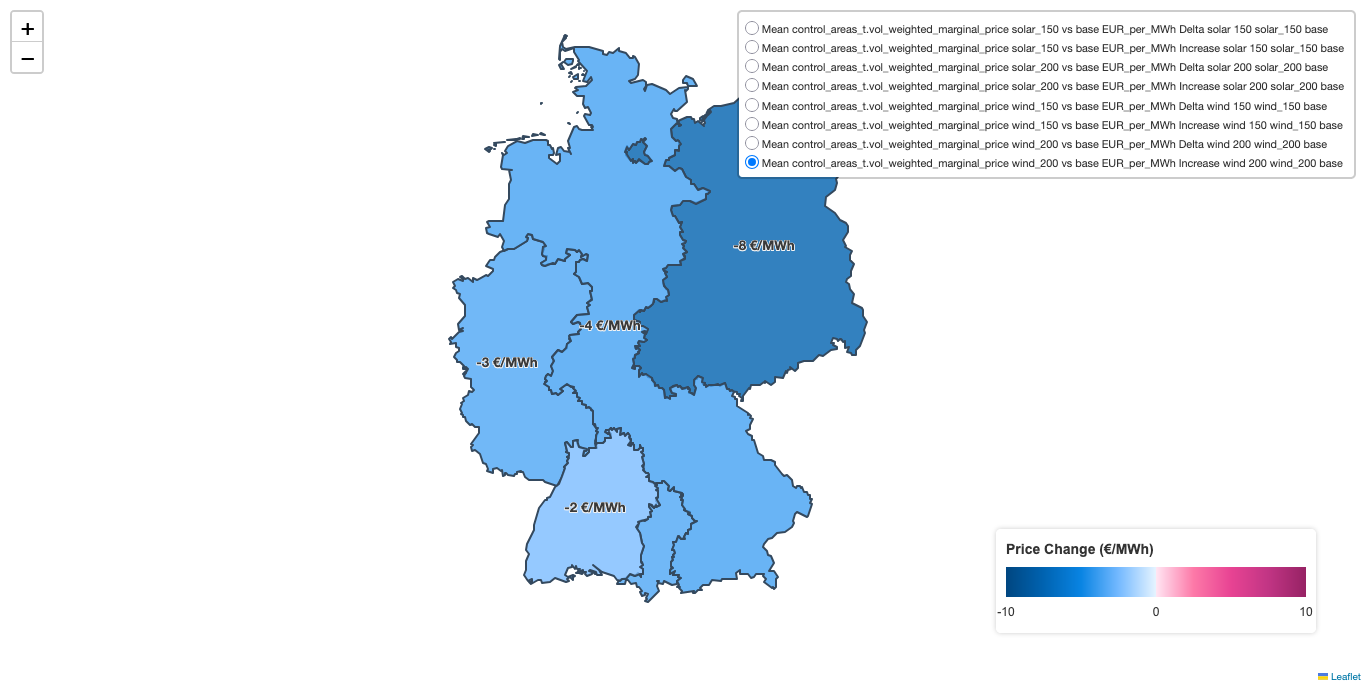

In [7]:
# Create diverging colorscale for price changes
price_change_colormap = vap.SegmentedContinuousColorscale(
    segments={
        (-10, 0): colors.sequential.shades_of_blue[::-1],
        (0, 10): colors.sequential.shades_of_pink,
    },
    nan_fallback='#CCCCCC'
)

# Create comparison visualization map
m2 = folium.Map(
    location=[51, 11],
    zoom_start=6,
    tiles=None
)
m2 = set_background_color_of_map(m2, color='#ffffff')

# Add legend for price changes
ContinuousColorscaleLegend(
    mapping=price_change_colormap,
    title="Price Change (€/MWh)",
    width=300,
    position={'bottom': 50, 'right': 50}
).add_to(m2)

# Create area generator for price changes
price_change_generator = fiz.AreaGenerator(
    fiz.AreaFeatureResolver(
        fill_color=fiz.PropertyMapper.from_kpi_value(price_change_colormap),
        fill_opacity=0.8,
        border_color='#34495e',
        border_width=2,
        tooltip=True
    )
)

# Filter comparison KPIs for price changes using new API
price_change_kpis = comparison_kpi_collection.filter_by_kpi_attributes(
    filter_funcs=dict(flag=lambda f: 'price' in f)
)

print(f"Found {price_change_kpis.size} price change KPIs")

# Visualize price changes
fiz.KPICollectionMapVisualizer(
    generators=[price_change_generator, fiz.TextOverlayGenerator()]
).generate_and_add_feature_groups_to_map(price_change_kpis, m2, show='last')

folium.LayerControl(collapsed=False).add_to(m2)
renderer.show_folium(m2)

## Part 3: Multi-KPI Visualization

Let's create a comprehensive map showing multiple KPI types with layer controls:

KPICollectionMapVisualizer:  80%|████████  | 5692/7115 [00:05<00:01, 1125.52it/s]


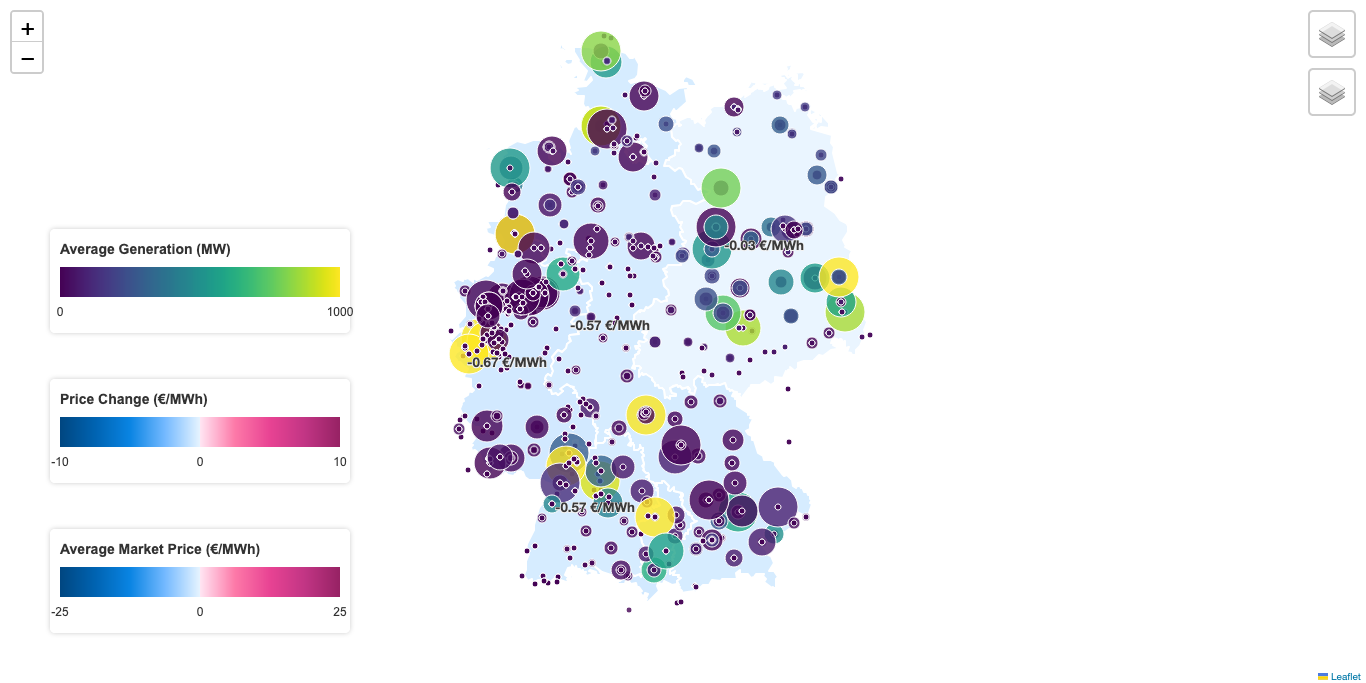

In [8]:
# Create comprehensive map with multiple KPI layers
m3 = folium.Map(
    location=[51, 11],
    zoom_start=6,
    tiles=None
)
m3 = set_background_color_of_map(m3, color='#ffffff')

# Define different colorscales for different KPI types
generation_colorscale = vap.SegmentedContinuousColorscale.single_segment_autoscale_factory_from_array(
    values=[0, 1000],
    color_range='viridis',
)

colorscales = {
    'price': {'pos': {'bottom': 50, 'left': 50}, 'scale': price_colorscale, 'title': "Average Market Price (€/MWh)"},
    'change': {'pos': {'bottom': 200, 'left': 50}, 'scale': price_change_colormap, 'title': "Price Change (€/MWh)"},
    'generation': {'pos': {'bottom': 350, 'left': 50}, 'scale': generation_colorscale, 'title': "Average Generation (MW)"},
}

for k, v in colorscales.items():
    ContinuousColorscaleLegend(
        mapping=v['scale'],
        title=v['title'],
        width=280,
        position=v['pos']
    ).add_to(m3)

from shapely import Point

# In this case, we don't have a "location" column ready in the generator model df, so we create the location on demand
def _get_location_of_generator(gen_data_item: fiz.VisualizableDataItem) -> Point:
    lat = gen_data_item.get_object_attribute('bus_y')
    lon = gen_data_item.get_object_attribute('bus_x')
    return Point([lon, lat])

# Visualize market prices for scenarios using new filtering API
price_fgs = (
    fiz.KPICollectionMapVisualizer(
        generators=[
            fiz.AreaGenerator(
                fiz.AreaFeatureResolver(
                    fill_color=fiz.PropertyMapper.from_kpi_value(colorscales['price']['scale']),
                    fill_opacity=0.8,
                    border_width=2,
                    tooltip=True
                )
            ),
            fiz.TextOverlayGenerator()
        ]
    )
    .generate_and_add_feature_groups_to_map(
        kpi_collection=scenario_kpi_collection.filter_by_kpi_attributes(filter_funcs=dict(flag=lambda f: 'price' in f)),
        folium_map=m3,
        show="none"
    )
)

# Visualize price changes for comparisons - filter by both flag and value_comparison
price_change_fgs = (
    fiz.KPICollectionMapVisualizer(
        generators=[
            fiz.AreaGenerator(
                fiz.AreaFeatureResolver(
                    fill_color=fiz.PropertyMapper.from_kpi_value(colorscales['change']['scale']),
                    fill_opacity=0.8,
                    border_width=2,
                    tooltip=True
                )
            ),
            fiz.TextOverlayGenerator()
        ]
    )
    .generate_and_add_feature_groups_to_map(
        kpi_collection=(
            comparison_kpi_collection
            .filter_by_kpi_attributes(filter_funcs=dict(flag=lambda f: 'price' in f))
            .filter(value_comparison=ValueComparisons.Increase)
        ),
        folium_map=m3,
        show='first'
    )
)

# Visualize generation for scenarios
generation_fgs = (
    fiz.KPICollectionMapVisualizer(
        generators=[
            fiz.CircleMarkerGenerator(
                fiz.CircleMarkerFeatureResolver(
                    fill_color=fiz.PropertyMapper.from_kpi_value(colorscales['generation']['scale']),
                    radius=fiz.PropertyMapper.from_item_attr('p_nom', lambda p: max(min(20, p / 50), 3)),
                    fill_opacity=0.8,
                    border_width=1,
                    tooltip=True,
                    location=fiz.PropertyMapper(_get_location_of_generator)
                )
            ),
            fiz.TextOverlayGenerator()
        ]
    )
    .generate_and_add_feature_groups_to_map(
        kpi_collection=scenario_kpi_collection.filter(flag='generators_t.p'),
        folium_map=m3,
        show='first'
    )
)

folium.LayerControl(collapsed=True).add_to(m3)

from folium.plugins import GroupedLayerControl
GroupedLayerControl(
    groups={'Area Fgs': price_fgs + price_change_fgs, 'Generator Fgs': generation_fgs},
    exclusive_groups=False,
    collapsed=True,
).add_to(m3)


renderer.show_folium(m3)

## Summary: KPI Visualization System Architecture

Let's summarize the key components and patterns we've demonstrated:

### Key Components Demonstrated:
- 📊 KPIDataItem: Wraps KPI objects for visualization pipeline
- 🎨 PropertyMapper.from_kpi_value(): Maps KPI values to visual properties
- 🔍 KPI Collection Filtering: By attributes, scenarios, and types
- 🗺️ KPICollectionMapVisualizer: Automatic map generation
- 🎛️ Multi-layer visualization: Different KPI types on same map
- 📈 Custom styling: Based on KPI magnitude and significance

### Visualization Patterns:
- Scenario Comparison: Toggle and Delta visualization with diverging colors
- Multi-KPI Dashboards: Layer controls for different metrics
- Significance Encoding: Opacity/border based on value magnitude
- Interactive Features: Tooltips, popups, and layer controls

### Advanced Features:
- ✨ Automatic tooltip generation from KPI attributes
- 🎯 KPI filtering for flexible selection
- 📏 Custom colorscales for different data ranges
- 🔄 Dynamic styling based on KPI properties
- 📊 Integration with MESQUAL's scenario comparison framework